In [147]:
using CSV, Plots, DataFrames, LinearAlgebra
data = CSV.read("/Users/tomer/Documents/Stanford/AA236A/BMX160/sensordata2.csv");

Plots.GRBackend()

## The data was collected at a sampling rate of 20Hz over a 15 hour interval  during which the board was stationary on a table. 

## Plotting the raw data, we can note that the sensors have constant bias, random white noise, and  brownian motion noise (random walk)

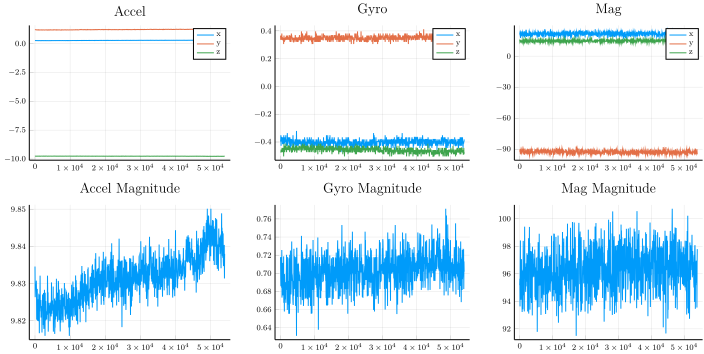

In [280]:
r = range(1, nrow(data), step = 1000)

rowwise_mags(r, str::String) = norm.(eachrow(data[r, Symbol.(str.*["x","y","z"])]))
rowwise_mags(r, sym::Symbol) = rowwise_mags(r, string(sym))

plots = []
magplots = []
for s in ["accel", "gyro", "mag"]
    p = plot(title = uppercasefirst(s))
    # individual plots
    for i in ["x", "y", "z"]
        plot!(p, data[r, :dt], data[r, Symbol(s*i)], label = i)
    end
    push!(plots, p)

    # Magnitudes:    
    push!(magplots, plot(data[r, :dt], rowwise_mags(r, s), 
            title = titlecase(s * " magnitude"), label = ""))
end


plot(plots..., magplots..., size = (1000, 500))

## Next compute the Allan Deviation of the data, and use that to find the parameters for noise, random walk, and bias instability. This is done for each axis -- x, y, z. The "average" characteristics are also found, by averaging the calculated allan deviation at each tau and repeating the procedure


In [ ]:
# Dictionary to keep track of the parameters
PARAMS = Dict{Symbol, NamedTuple}()

In [348]:
using AllanDeviations, StatsBase, LaTeXStrings

"""
This function directly follows the procedure in:
https://www.mathworks.com/help/nav/ug/inertial-sensor-noise-analysis-using-allan-variance.html
to find the coefficients.
"""
function random_walk_line_coeffs(tau, adev)
    # log-scaled Tau and Allan deviation (as they will appear on the log-log plot):
    logtau = log10.(tau)
    logadev = log10.(adev)
    dlogadev = diff(logadev) ./ diff(logtau)
    
    # Each charateristic corresponds to a slope (that has to do with its 
    # power spectral density (PSD); see link above). Once the correct tangent is found 
    # (on the log plot), the y-intercept of that line is found. Based on the PSD equation 
    # of the desired noise and the line equation, the parameter can be read off at a 
    # particular tau value.
    slopes = [-0.5, 0.5, 0.0]
    log_tau_val = [0.0, 
                   0.5*log10(3), 
                   -log10(sqrt(2*log(2)/pi))]
    
    NKB = map(zip(slopes, log_tau_val)) do (s, lt)
        m, i = findmin(abs.(dlogadev .- s))
        b = logadev[i] - s*logtau[i]
        logprm = lt + b
        prm = 10^logprm
        (prm, i)
    end
    
    return mapreduce(collect, vcat, NKB)
end


function characterization_plot(tau, adev, N, iN, K, iK, B, iB; title = "")
    p = plot(tau, adev, legend = :bottomleft, scale = :log10, 
        title = title, label = L"\sigma(\tau)")
    
    # line functions for each one:
    lineN = x -> N / sqrt(x)
    lineK = x -> K * sqrt(x/3)
    lineB = x -> B * sqrt(2*log(2)/pi) # horizontal line

    plot!(p, tau, [lineN, lineK, lineB], scale = :log10, 
          style = :dash, labels = ["Angle RW", "Rate RW", "Bias instability"])
  
    scatter!(p, [(tau[iN], lineN(tau[iN])),
                 (tau[iK], lineK(tau[iK])),
                 (tau[iB], lineB(tau[iB]))], labels = "")
    return p
end

"""
Essentially `main`. Computes the allan variance of a sensor subset of 
the data, and places the noise parameters in the global params dict. 
Returns plots showing the fitted characteristics.
"""
function group_plot_data(data, sensorsym, resolution = 0.05)
    plots = []
    sensor_names = Symbol.(string(sensorsym) .* ["x", "y", "z"])
    
    results = [allandev(data[:, s], resolution, frequency = true) for s in sensor_names]
    
    tau = results[1].tau
    
    adevs = [d.deviation for d in results]
    meandev = map(mean, zip(adevs...))
    push!(adevs, meandev)
    
    for (s, d, t) in zip([sensor_names; sensorsym], 
                          adevs, 
                          [sensor_names; "average"])
        N, iN, K, iK, B, iB = random_walk_line_coeffs(tau, d)
                
        # global params dict
        PARAMS[s] = (N = N, K = K, B = B)
                
        p = characterization_plot(tau, d, N, iN, K, iK, B, iB, title = "$t characterization")
        push!(plots, p)
    end

    return plots
end

group_plot_data

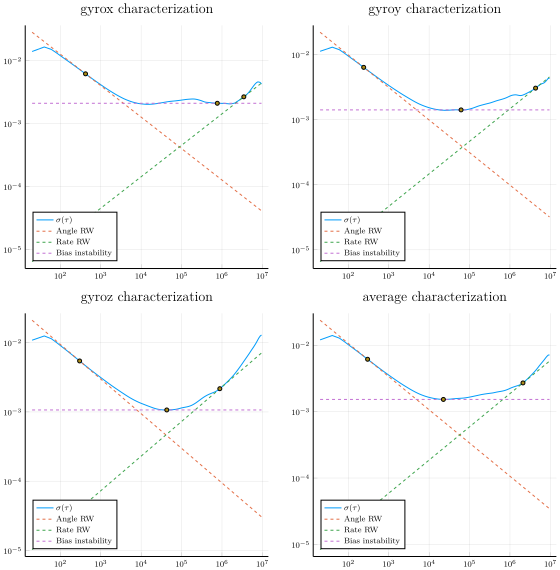

In [349]:
 plot(group_plot_data(data, :gyro)..., size = (800, 800))

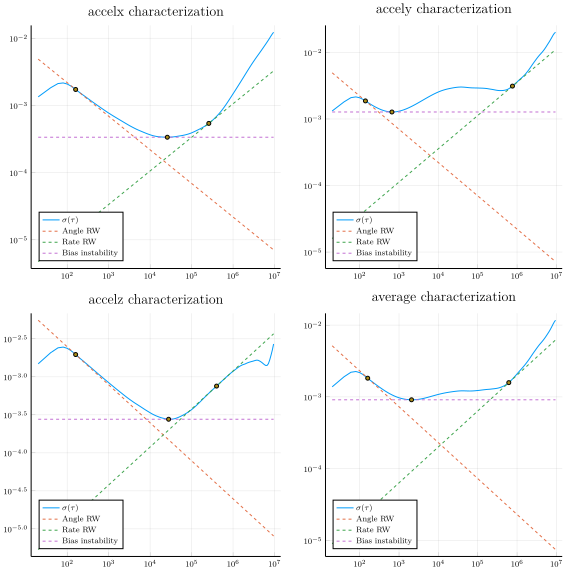

In [350]:
 plot(group_plot_data(data, :accel)..., size = (800, 800))

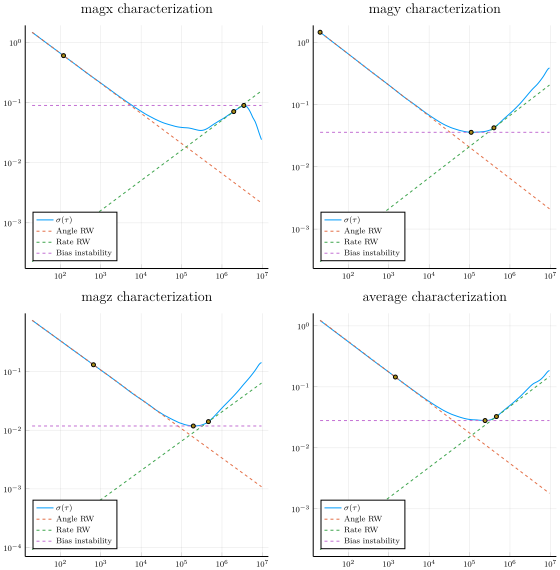

In [351]:
 plot(group_plot_data(data, :mag)..., size = (800, 800))

## The calculated parameters. The parameters can be composed into a sensor model like the ones described in https://www.mathworks.com/help/nav/ref/imusensor-system-object.html

In [352]:
D = DataFrame(name = collect(keys(PARAMS)),
              white_noise_param = [x.N for x in values(PARAMS)],
              brownian_noise_param = [x.K for x in values(PARAMS)],
              pink_noise_param = [x.B for x in values(PARAMS)])
sort(D, :name)

,name,white_noise_param,brownian_noise_param,pink_noise_param
,Symbol,Float64,Float64,Float64
1,accel,0.0230514,3.48312e-6,0.0013723
2,accelx,0.0218412,1.83386e-6,0.000506002
3,accely,0.0221252,6.17802e-6,0.00191791
4,accelz,0.0248552,2.06823e-6,0.000416573
5,gyro,0.10647,3.23529e-6,0.00229887
6,gyrox,0.12688,2.47942e-6,0.00317132
7,gyroy,0.0986551,2.54743e-6,0.00212694
8,gyroz,0.0943125,3.98811e-6,0.00160857
9,mag,5.53702,8.29201e-5,0.0421781
